In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys
sys.path.append('../..')
import pandas as pd
from model import VAE
from Model import input_pipeline
from Model.results import get_df, get_stats, final_plot
from joblib import load

# Helper functions

In [5]:
def sample_normal(num_examples_to_generate, model):
    latent_dim = model.latent_dim
    random_mean = tf.random.normal(mean = 0, stddev=1 ,
        shape=[num_examples_to_generate, latent_dim])
    log_var = tf.random.normal(mean = 0, stddev=1,
        shape=[num_examples_to_generate, latent_dim])
    z = model.reparameterize(random_mean, log_var)
    predictions = model.sample(z)
    return predictions
    
def plus_encode_data(data):
    data = tf.reshape(data, shape=(data.shape[0], -1))
    mean_data = tf.reduce_mean(data, axis=1, keepdims=True)
    need_change = tf.cast(mean_data < 0.5, data.dtype)
    data = data * (1 - 2 * need_change) + need_change
    data = tf.reshape(data, shape=(-1, 32, 32, 1))
    return data   
    
def random_swap(data):
    data = tf.reshape(data, shape = (data.shape[0], -1))
    swap_mask = 2 * (np.random.random(size = (data.shape[0], 1)) > 0.5) - 1
    data = tf.multiply(data, swap_mask)
    data = tf.reshape(data, shape = (-1, 32, 32, 1))
    return data
    
def sample_gm(num_examples_to_generate, vae, gm_mean, gm_var):
    random_mean, _ = gm_mean.sample(num_examples_to_generate)
    log_var, _ = gm_var.sample(num_examples_to_generate)
    random_mean = tf.cast(random_mean, tf.float32)
    log_var = tf.cast(log_var, tf.float32)
    z = vae.reparameterize(random_mean, log_var)
    predictions = vae.sample(z)
    return predictions

def load_model_at_T(t, folder, latent_dim = 200):
    model = VAE(latent_dim)
    dummy_input = tf.zeros((1, 32, 32, 1))
    model(dummy_input)
    model.load_weights(f'Results/{folder}/vae{t:.1f}.h5')
    gm_mean = load(f'Results/{folder}/{t:.1f}/gm_means.pkl')
    gm_var = load(f'Results/{folder}/{t:.1f}/gm_vars.pkl')
    return model, gm_mean, gm_var

## Models dictionary

In [6]:
temps = np.arange(2.0, 3.05, 0.1)
titles = [f"Temperature: {t:.1f}" for t in temps]
folder = "16-04-2024"
models = {t: load_model_at_T(t, folder) for t in temps}

/home/ps/.local/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator GaussianMixture from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Compare with monte carlo

## Mean Var expermients

In [ ]:
temp = 3.0
model = load_model_at_T(temp)
batch_size = 5000

trainset_path = f"../../GetData/Python/Data/Data{temp:.1f}.tfrecord"
train_set = input_pipeline.dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)

testset_path = f"../../GetData/Python/Data/TestData{temp:.1f}.tfrecord"
test_set = input_pipeline.dataset_tfrecord_pipeline(testset_path, flatten=False, batch_size=batch_size)

# data mc trainset
data_mc = next(iter(train_set))
data_plus = plus_encode_data(data_mc)
encoded = model.encode(data_plus)
data_mc = 2 * data_mc - 1
df_monte_carlo = get_df(data_mc)

# logvar, mean
means, vars =  encoded
means = means.numpy()
vars = vars.numpy()

# data testset encoded
data_test = next(iter(test_set))
test_reconstructed = model(data_test)
test_sample = 2 * np.random.binomial(1, test_reconstructed) - 1
df_test = get_df(test_sample)

# empirical logvar and mean
sample_data_std = sample_new(batch_size, model, means, vars)
sample_data_std = 2 * np.random.binomial(1, sample_data_std) - 1
spin_sample = random_swap(spin_sample)
df_sampled_std = get_df(sample_data_std)

# normal logvar and mean
sample_data = sample(batch_size, model)
spin_sample = 2 * np.random.binomial(1, sample_data) - 1
spin_sample = random_swap(spin_sample)
df_sampled = get_df(spin_sample)

In [ ]:
df_sampled['Type'] = 'Sampled from N(0,1)'
df_monte_carlo['Type'] = 'Monte Carlo'
df_test['Type'] = 'Testset decoded'
df_sampled_std['Type'] = 'Sampled from empirical '
df = pd.concat([df_sampled, df_monte_carlo, df_test, df_sampled_std])

In [ ]:
import seaborn as sns

sns.displot(data=df, x='Magnetization', kind='kde', hue = 'Type', alpha=0.5)
plt.savefig("Magnetization.png")
sns.displot(data=df, x='Energy', kind='kde', hue = 'Type', alpha=0.5)
plt.savefig("Energy.png")

## Kolmogorov-Smirnov test

In [ ]:
from scipy import stats

def ks_test(data, means = None, variances = None):
    if means is None:
        means = np.mean(data, axis=0)
    if variances is None:
        variances = np.var(data, axis=0)
    ks_results = [stats.kstest(data[:, i], 'norm', args=(means[i], np.sqrt(variances[i]))).pvalue for i in range(data.shape[1])]
    return ks_results

In [ ]:
import matplotlib.pyplot as plt

# Assuming ks_means and ks_variances are your data
ks_means = ks_test(means)
ks_variances = ks_test( vars)

# Assuming ks_means and ks_variances are your data
ks_means_standard = ks_test(means, np.zeros(shape=200), np.ones(shape=200))
ks_variances_standard = ks_test(vars, np.zeros(shape=200), np.ones(shape=200))

# Set the style
plt.style.use('ggplot')

# Create a figure and a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Plot the histograms on the subplots
axs[0][0].hist(ks_means)
axs[0][0].set_title('Means dist. compared with empirical normal dist.')

axs[0][1].hist(ks_variances)
axs[0][1].set_title('Logvariances dist. compared with empirical normal dist.')

# Plot the histograms on the subplots
axs[1][0].hist(ks_means_standard, bins=10)
axs[1][0].set_title('Means dist. compared with N(0, 1)')

axs[1][1].hist(ks_variances_standard, bins=10)
axs[1][1].set_title('Logvariances dist. compared with N(0, 1)')
axs[1][1].set_xlim(-.05,1)

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Adjust the top padding to make room for the suptitle

# Display the figure with its subplots
plt.savefig("ks_test.png")
plt.show()


# Data

In [7]:
data_list = []
for temp in temps:

    trainset_path = f"../../GetData/Python/Data/Data{temp:.1f}.tfrecord"
    batch_size = 100
    train_set = input_pipeline.dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)
    
    vae, gm_mean, gm_var = models[temp]
    data_mc = []
    data_normal = []
    data_gm = []
    for data in train_set:
        data_mc.append(data)
        data_normal.append(sample_normal(batch_size, vae))
        data_gm.append(sample_gm(batch_size, vae, gm_mean, gm_var))
    
    data_mc = np.concatenate(data_mc)
    data_normal = np.concatenate(data_normal)
    data_gm = np.concatenate(data_gm)
    
    data_mc = 2 * data_mc - 1
    data_gm = 2 * np.random.binomial(1, data_gm) - 1
    data_normal = 2 * np.random.binomial(1, data_normal) - 1

    # Monte Carlo
    df_monte_carlo = get_df(data_mc)
    mc_stats = get_stats(df_monte_carlo, temp)
    mc_stats.extend((temp, "Monte Carlo"))


    # VAE normal
    data_normal = random_swap(data_normal)
    df_sampled = get_df(data_normal)
    normal_stats = get_stats(df_sampled, temp)
    normal_stats.extend((temp, "Sampled VAE normal"))
    
    # VAE gm
    data_gm = random_swap(data_gm)
    df_sampled = get_df(data_gm)
    gm_stats = get_stats(df_sampled, temp)
    gm_stats.extend((temp, "Sampled VAE gm"))
    
    # Append to data list
    data_list.append(mc_stats)
    data_list.append(gm_stats)
    data_list.append(normal_stats)

2024-04-17 11:15:06.603524: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 409600000 exceeds 10% of free system memory.
2024-04-17 11:15:06.983761: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 409600000 exceeds 10% of free system memory.
2024-04-17 11:15:33.997474: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 409600000 exceeds 10% of free system memory.
2024-04-17 11:15:34.380090: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 409600000 exceeds 10% of free system memory.
2024-04-17 11:19:01.988892: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 409600000 exceeds 10% of free system memory.


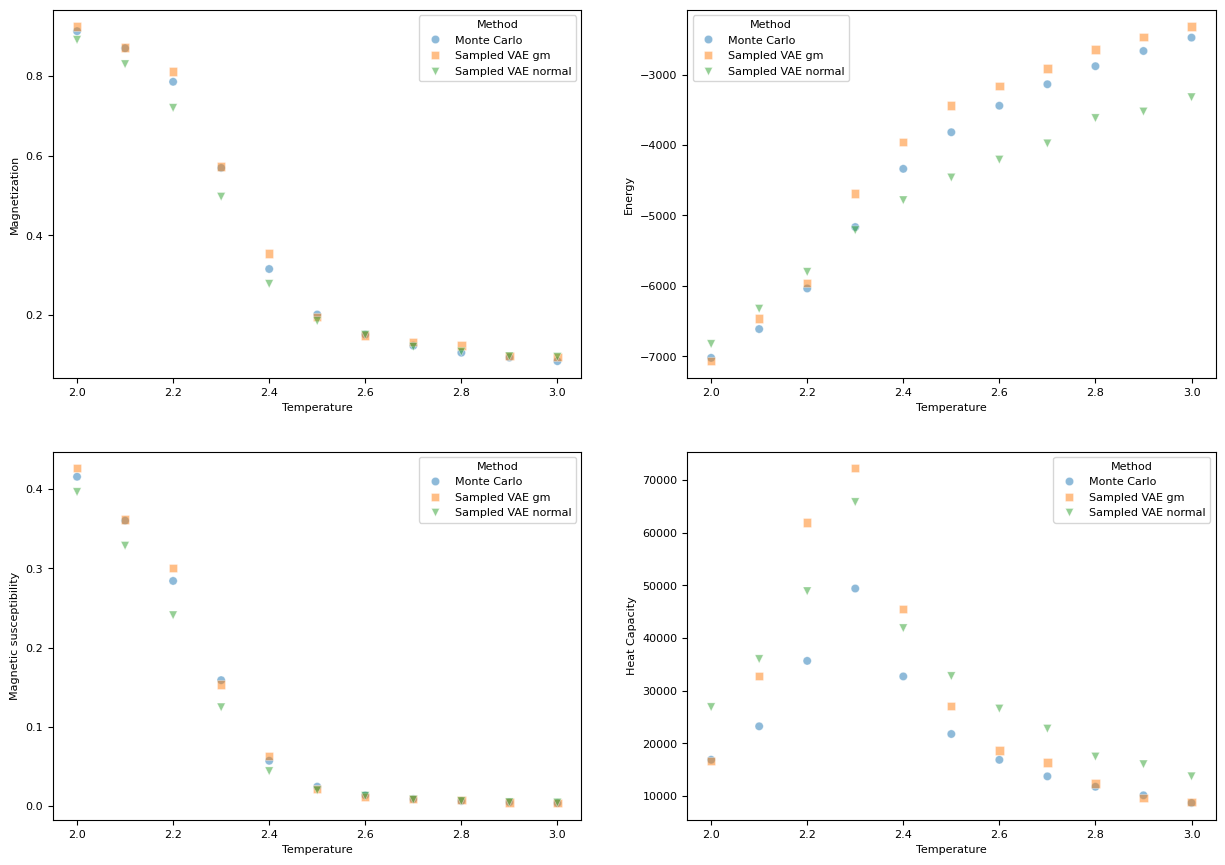

In [25]:
df = pd.DataFrame(data_list, columns=['Magnetization', 'Energy', 'Magnetic susceptibility', 'Heat Capacity', 'Temperature', 'Method'])
final_plot(df)

In [ ]:
import math

ncols = math.ceil(len(temps) / 2)
fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(20, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(temps):
        ax.set_title(titles[i], fontsize=20)
        predictions = sample_normal(1, models[temps[i]])
        ax.yaxis.set_ticklabels([])
        ax.xaxis.set_ticklabels([])
        spins = np.random.binomial(1, predictions[0, :, :])
        ax.imshow(spins, vmin=0, vmax=1)
    else:
        ax.axis('off')

plt.subplots_adjust(hspace=0.1f5)
plt.tight_layout()
plt.savefig("example.svg")
plt.savefig("example.png")